# Here comes the sun
> When does the sun rise and set? I have a fuzzy idea about how this works, here I want to make it a little bit less fuzzy.

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [math]
- image: https://exitoina.uol.com.br/media/_versions/beatlessss_widelg.jpg
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

## Using suntime package
Eventhough this could be cheating, it's a good starting point to get a feel...
This example is taken straight from the documentation:

In [1]:
#collapse
import datetime
from suntime import Sun, SunTimeException

latitude = 51.21
longitude = 21.01

sun = Sun(latitude, longitude)

# Get today's sunrise and sunset in UTC
today_sr = sun.get_sunrise_time()
today_ss = sun.get_sunset_time()
print('Today ({}) at Warsaw the sun raised at {} and get down at {} UTC'.
      format(datetime.datetime.today().strftime('%Y-%m-%d'), today_sr.strftime('%H:%M'), today_ss.strftime('%H:%M')))

# On a special date in your machine's local time zone
abd = datetime.date(2014, 10, 3)
abd_sr = sun.get_local_sunrise_time(abd)
abd_ss = sun.get_local_sunset_time(abd)
print('On {} the sun at Warsaw raised at {} and get down at {}.'.
      format(abd, abd_sr.strftime('%H:%M'), abd_ss.strftime('%H:%M')))

# Error handling (no sunset or sunrise on given location)
latitude = 87.55
longitude = 0.1
sun = Sun(latitude, longitude)
try:
    abd_sr = sun.get_local_sunrise_time(abd)
    abd_ss = sun.get_local_sunset_time(abd)
    print('On {} at somewhere in the north the sun raised at {} and get down at {}.'.
          format(abd, abd_sr.strftime('%H:%M'), abd_ss.strftime('%H:%M')))
except SunTimeException as e:
    print("Error: {0}.".format(e))

I currently live here: 58°04'00.8"N 11°42'10.7"E

This one can be converted to [Decimal degrees](https://en.wikipedia.org/wiki/Decimal_degrees).

In [2]:
def longitude_str_to_num(s:str):
    """
    Convert a longitude or latitude in the following format : 58°04'00.8"N
    to degrees
    """
    
    s1,s_=s.split('°')
    s2,s_=s_.split("'")
    s3,s_=s_.split('"')
    
    
    D = float(s1)
    M = float(s2)
    S = float(s3)
    
    D_deg = D + M/60 + S/3600
    
    if (s_=='W') or (s_=='S'):
        D_deg*=-1
    
    
    return D_deg

In [3]:
latitude = longitude_str_to_num('58°04\'00.8"N')
latitude

In [4]:
longitude = longitude_str_to_num('11°42\'10.7"E')
longitude

In [5]:
sun = Sun(latitude, longitude)

In [6]:
sunrise_time = sun.get_sunrise_time()
sunrise_time

In [7]:
sunset_time = sun.get_sunset_time()
sunset_time

Getting these times in local time zone is somewhat messy:

In [8]:
import pytz
timezone = pytz.timezone(r'Europe/Stockholm')
sunrise_time.replace(tzinfo=pytz.utc).astimezone(timezone)

datetime.datetime(2020, 11, 2, 7, 31, tzinfo=<DstTzInfo 'Europe/Stockholm' CET+1:00:00 STD>)

## Own implementation

The [Sun rise equation](https://en.wikipedia.org/wiki/Sunrise_equation) is written:
$$\cos \omega_{\circ}=-\tan \phi \times \tan \delta$$
where $\phi$ is the latitude and $\delta$ is the earth inclination angle to the sun, which changes over the seasons.

The [declination-angle](https://www.pveducation.org/pvcdrom/properties-of-sunlight/declination-angle) can be calculated:
$$ \delta=-23.45^{\circ} \times \cos \left(\frac{360}{365} \times(d+10)\right) $$
where $d=1$ at january 1st.

Putting it all together:

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_declination_angle(day):
    angle_deg=360/365*(day+10)
    delta_deg = -23.45*np.cos(np.deg2rad(angle_deg))
    delta = np.deg2rad(delta_deg)    
    return delta    

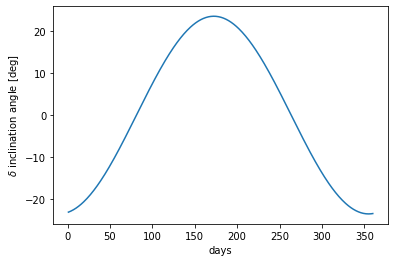

In [10]:
#collapse
days=np.linspace(1,360,360)
delta=calculate_declination_angle(day=days)

fig,ax=plt.subplots()
ax.plot(days,np.rad2deg(delta));
ax.set_xlabel('days')
ax.set_ylabel('$\delta$ inclination angle [deg]');

In [11]:
def sun_hour_angle(latitude:float, day:int):
    """
    param: latitude [deg]
    param: day, january 1 --> day=1
    """
    delta = calculate_declination_angle(day=day)
    phi=np.deg2rad(latitude)
    omega0 = np.arccos(-np.tan(phi)*np.tan(delta))
    
    return omega0

def sun_rise_time(latitude:float, day:int):
    """
    param: latitude [deg]
    param: day, january 1 --> day=1
    """
    omega0 = sun_hour_angle(latitude=latitude, day=day)
    rise_time=12-omega0/np.deg2rad(15)
    return rise_time

def sun_set_time(latitude:float, day:int):
    """
    param: latitude [deg]
    param: day, january 1 --> day=1
    """
    omega0 = sun_hour_angle(latitude=latitude, day=day)
    set_time=12+omega0/np.deg2rad(15)
    
    return set_time
    
    

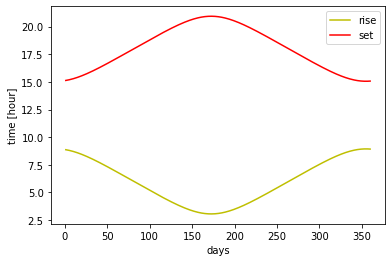

In [12]:
#collapse

rise_time=sun_rise_time(latitude=latitude, day=days)
set_time=sun_set_time(latitude=latitude, day=days)


fig,ax=plt.subplots()
ax.plot(days,rise_time, label='rise', color='y');
ax.plot(days,set_time, label='set', color='r');
ax.legend()
ax.set_xlabel('days')
ax.set_ylabel('time [hour]');


In [13]:
now = datetime.datetime.now()
day = (now-datetime.datetime(year=now.year, month=1, day=1)).days
rise_time = sun_rise_time(latitude=latitude, day=day)
rise_time = datetime.timedelta(hours=rise_time)
'%s' % rise_time

'7:46:23.220795'

... so we are missing with about 15 minutes compared to the previous result. I think that the given time here is by definition in local time, since we substract from local time 12 o'clock as in the code above.

Wikipedia also says that there is a more advanced [Sun rise equation](https://en.wikipedia.org/wiki/Sunrise_equation):

$$ \cos \omega_{\circ}=\frac{\sin a-\sin \phi \times \sin \delta}{\cos \phi \times \cos \delta} $$
where $a=−0.83°$

Will that fix the 15 minutes?

In [14]:
#collapse
from numpy import sin,cos 

def sun_hour_angle2(latitude:float, day:int):
    """
    param: latitude [deg]
    param: day, january 1 --> day=1
    """
    delta = calculate_declination_angle(day=day)
    phi=np.deg2rad(latitude)
    a = np.deg2rad(-0.83)
    
    omega0 = np.arccos((sin(a)-sin(phi)*sin(delta))/(cos(phi)*cos(delta)))
    return omega0

def sun_rise_time2(latitude:float, day:int):
    """
    param: latitude [deg]
    param: day, january 1 --> day=1
    """
    omega0 = sun_hour_angle2(latitude=latitude, day=day)
    rise_time=12-omega0/np.deg2rad(15)
    return rise_time

def sun_set_time2(latitude:float, day:int):
    """
    param: latitude [deg]
    param: day, january 1 --> day=1
    """
    omega0 = sun_hour_angle2(latitude=latitude, day=day)
    set_time=12+omega0/np.deg2rad(15)
    
    return set_time

In [15]:
rise_time = sun_rise_time2(latitude=latitude, day=day)
rise_time = datetime.timedelta(hours=rise_time)
'%s' % rise_time

'7:39:09.322665'

...a little bit better but still not perfect. There was also a simplification in the calculation of the inclination angle, will that do it?

In [16]:
def calculate_declination_angle2(day):
    angle_deg=360/365*(day+10)    
    delta = np.arcsin(np.sin(np.deg2rad(-23.45))*np.cos(np.deg2rad(angle_deg)))
    return delta 

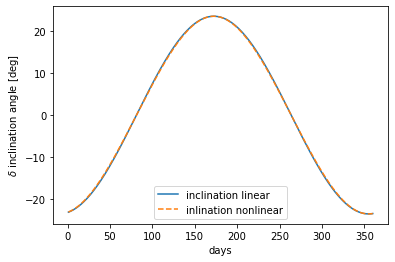

In [17]:
#collapse

delta=calculate_declination_angle(day=days)
delta2=calculate_declination_angle2(day=days)


fig,ax=plt.subplots()

ax.plot(days,np.rad2deg(delta),label='inclination linear');
ax.plot(days,np.rad2deg(delta2),'--', label='inlination nonlinear');

ax.set_xlabel('days')
ax.set_ylabel('$\delta$ inclination angle [deg]');
ax.legend()

In [18]:
#collapse

def sun_hour_angle3(latitude:float, day:int):
    """
    param: latitude [deg]
    param: day, january 1 --> day=1
    """
    delta = calculate_declination_angle2(day=day)
    phi=np.deg2rad(latitude)
    a = np.deg2rad(-0.83)
    
    omega0 = np.arccos((sin(a)-sin(phi)*sin(delta))/(cos(phi)*cos(delta)))
    return omega0

def sun_rise_time3(latitude:float, day:int):
    """
    param: latitude [deg]
    param: day, january 1 --> day=1
    """
    omega0 = sun_hour_angle3(latitude=latitude, day=day)
    rise_time=12-omega0/np.deg2rad(15)
    return rise_time

def sun_set_time3(latitude:float, day:int):
    """
    param: latitude [deg]
    param: day, january 1 --> day=1
    """
    omega0 = sun_hour_angle3(latitude=latitude, day=day)
    set_time=12+omega0/np.deg2rad(15)
    
    return set_time

In [19]:
rise_time = sun_rise_time3(latitude=latitude, day=day)
rise_time = datetime.timedelta(hours=rise_time)
'%s' % rise_time

'7:37:16.367648'

yet a little bit better, but there is still some time missing...

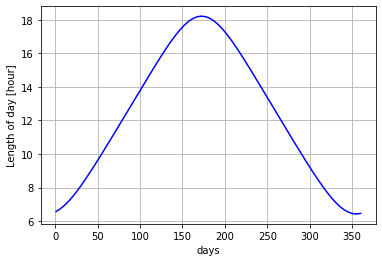

In [20]:
#collapse
def time_of_day(latitude:float, day:int):
    return sun_set_time3(latitude=latitude, day=day) - sun_rise_time3(latitude=latitude, day=day)

time=time_of_day(latitude=latitude, day=days)

fig,ax=plt.subplots()
ax.plot(days,time, 'b-', label='rise');
ax.set_xlabel('days')
ax.set_ylabel('Length of day [hour]');
ax.grid(True)

/Users/martinalexandersson/Dev/blog/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in arccos
  if sys.path[0] == '':


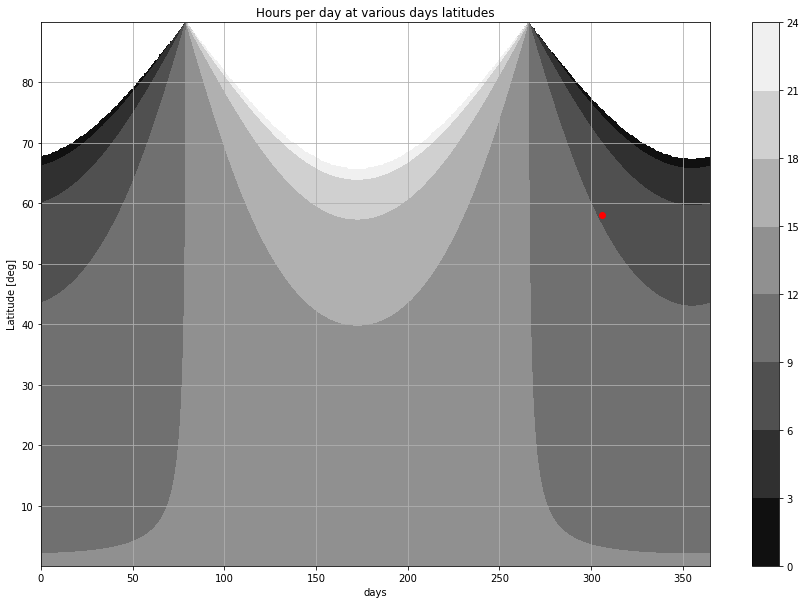

In [22]:
#collapse

from matplotlib import ticker, cm

N=400
latitudes = np.linspace(0.1,89.9,N)
days_ = np.linspace(0,365,N)
L = np.tile(latitudes,(len(days_),1))
D = np.tile(days_,(N,1)).T

time=time_of_day(latitude=L, day=D)

fig,ax=plt.subplots()
fig.set_size_inches(15,10)
cs = ax.contourf(D,L,time, cmap=cm.gray);
cb = fig.colorbar(cs)
ax.set_xlabel('days')
ax.set_ylabel('Latitude [deg]');
ax.grid(True)

latitude = longitude_str_to_num('58°04\'00.8"N')
ax.plot(day,latitude,'ro');
ax.set_title('Hours per day at various days latitudes');